# Data Description and EDA

# 1. Data Description and Summary
 

### 1) Experimental Protocol Details
The data used in this project was collected during tests session in the Wyss Motion Capture Lab, where 6 human subjects were asked to wear the soft sensing shirt and perform a series of arm motions. Each subject performed 3 trials of arm movements. Each trial contains 3 sequential conditions: 

* Pre-defined movements
* Composite movements 
* Random movements 

Pre-defined movements include shoulder abduction, flexion, extension, horizontal flexion, and horizontal extension; all from minimum to maximum range of motion. 
Composite movements include drawing a figure “∞” with the arm at different heights.
Random movements were trials where the subject was told to move the arm in a random manner for the duration of the trial.
The total number of observations (n) for these subjects are: 80137, 102941, 91690, 118276, 100600, and 108239.



### 2) Collected Data
Recorded data from each session includes timestamps, embedded sensor raw outputs (total of 6 sensors in the shirt), and the motion captured (MOCAP) shoulder angles (total of 3 degrees of freedom: shoulder adduction, horizontal flexion, and internal rotation). The MOCAP data is used as the angle ground truth. Therefore, the dataset has 7 initial predictors and 3 outcome variables.

#### 2a) Description of Raw Data? 

### 3) Data Cleaning
One thing that needed to be considered when first looking at the data is the fact in the variability present in ranges of values presented by the MOCAP data for the three angles: Abduction (ab), Horizontal Flexion (hf) and Internal Rotation (ir). This corresponds to the range of motion across all subjects in the three directions. Although the ranges are relatively consistent across the 6 subjects for hf and ab, the ir ranges fluctuate considerably. The variability here could be due to true inter-subject variability (linked to posture), as well as the lack of standardization of the definition of 0&deg; rotation in ir during the experimental data collection. 

**PUT FIGURES HERE**

Since the MOCAP is used as the ground truth for the model predictions, it was decided to develop a model using the data of a single subject to avoid any complications arising from using an inconsistent ground truth for ir across multiple subjects. This aligns with the goal of creating a model that would have a personalized calibration period for each individual who would use it to train the model, and then have the model predict for each subject. Later on, it may be worth extending the model to be more general, but the use case for the scope of this project to be a subject-individualized model. 


### 4) Dataset Selection
Once the decision to pursue a single-subject model, a single subject was selected from the 6 total subjects that were tested in the protocol. The data from the three separate trials, each containing the three conditions of pre-defined, composite, and random movements, were pooled together. Additionally, since the sampling frequency of the MOCAP system is very high (200 Hz), the dataset was downsampled to allow for faster computation time. 

### 5) Feature Selection and Engineering
For the initial data exploration, the timestamp data was dropped in order to remove absolute time-dependency from the model. This was done to mitigate the risk of the model being biased towards a certain outcome based on what time the motion was recorded since the protocol involved following a sequence of moments, which will not always be the case in later trials. 

However, since the arm motions are continuous, including previous sensor values may be useful in the models, especially in RNN and LSTM models, to predict future positions of the arm. For this purpose, the 1st and 2nd derivatives of the position of the arm were calculated and included as features. Additionally, for linear regression, polynomial features of order 2 were included as well. 



# 2. EDA

Initial EDA was done on the pooled data of a single subject - the 3 trials collected were concatenated to create a larger dataset. The initial approach was to look at the raw output of each of the 6 sensors embedded in the shirt during motion in the 3 directions (ab, hf, if), as well as to look at the reverse - the consistency with which data points with the arm in the same position have similar sensor values.

**Load Data**

In [3]:
df = pd.read_csv('../data/M1_t1A.txt', header=None, names=['time','s1','s2','s3','s4','s5','s6','hf','ab','ir'])
df.head()

,time,s1,s2,s3,s4,s5,s6,hf,ab,ir
0,0.000000,205.33,176.98,225.10,208.81,152.47,164.64,-12.149,20.124,-41.307
1,0.008333,205.32,177.00,225.06,208.67,152.41,164.62,-11.648,20.087,-40.909
2,0.016667,205.31,177.02,225.02,208.53,152.36,164.60,-11.142,20.047,-40.482
3,0.021000,205.30,177.03,225.00,208.45,152.34,164.59,-10.891,20.025,-40.246
4,0.025000,205.30,177.04,224.98,208.38,152.31,164.59,-10.659,20.004,-40.028


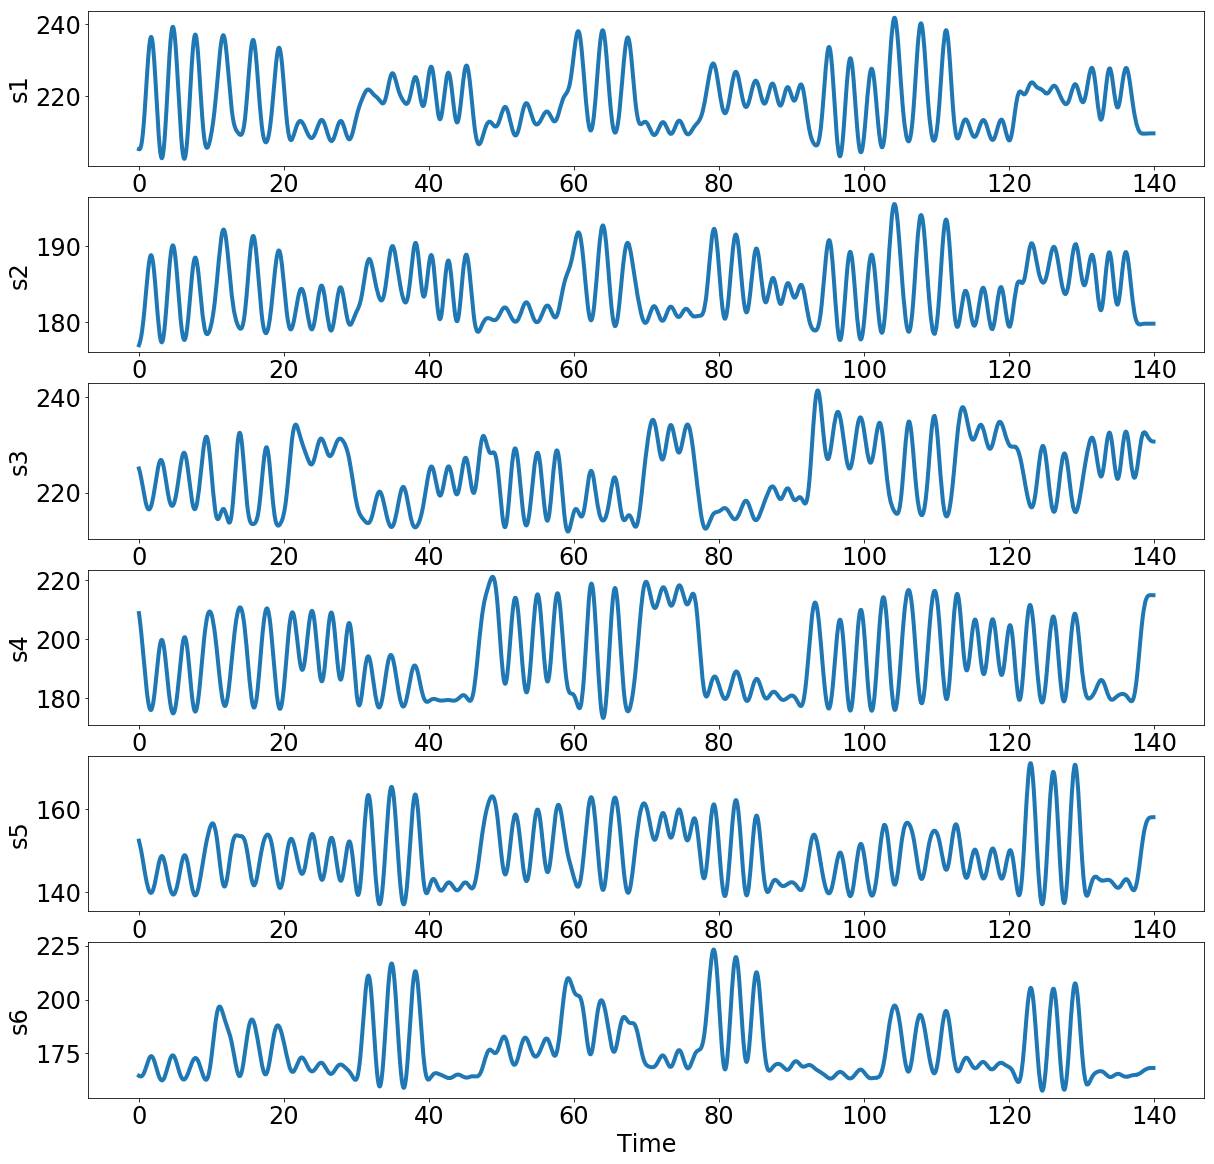

In [6]:
fig, ax = plt.subplots(n_sens, 1, figsize=(20,20))

for k in range(0,n_sens):
    ax[k].plot(df.time,df[sens[k]])
    ax[k].set_ylabel(sens[k])
    
ax[-1].set_xlabel('Time');

#### Comments: 
From the plot above it is visible that there is a distinct difference shown in certain sensors during movement in each of the three directions - this leads us to believe that using some subset of the signals output by the embedded sensors will be a viable way of predicting a corresponding arm angle. For clarification, the plot above was made prior to the feature removal of the timestamp for visualization purposes. 

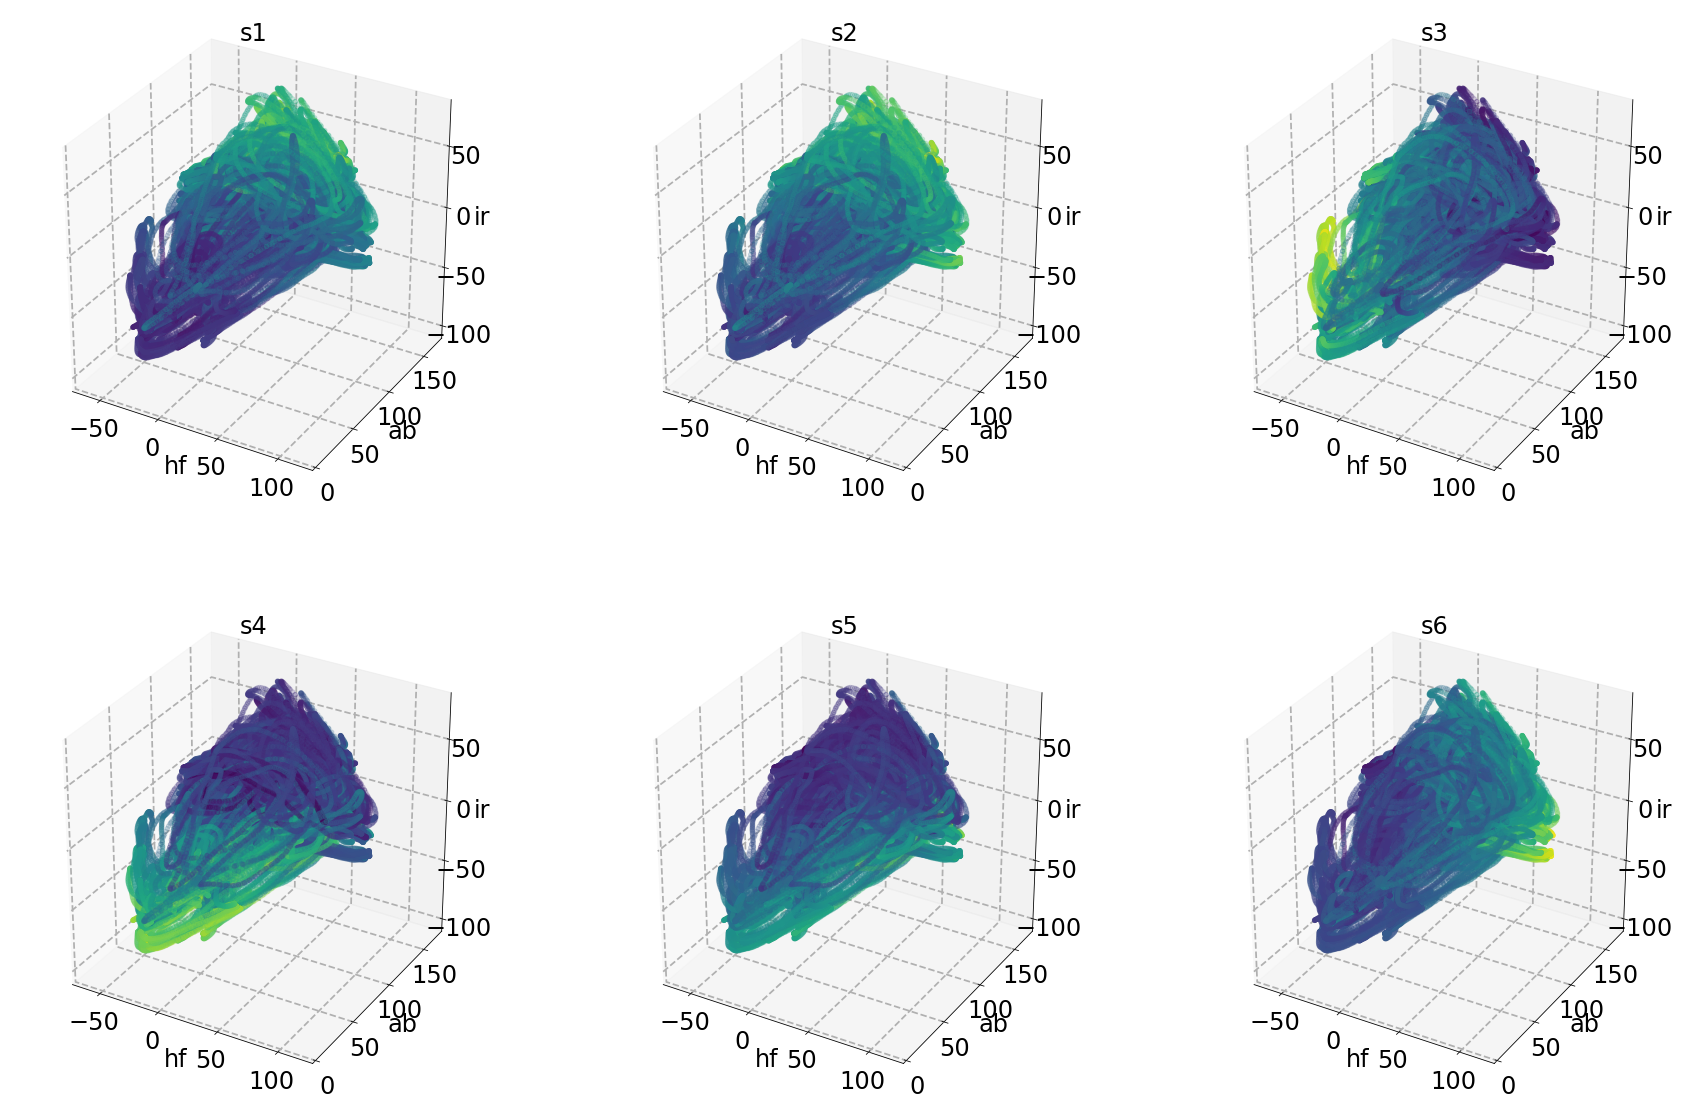

In [105]:
# pooled data 3D plot

cm = plt.get_cmap('viridis')
fig = plt.figure(figsize=(30,20))

for k in range(6):
    ax = fig.add_subplot(2,3,k+1,projection='3d')
#     ax.view_init(elev=-90,azim=0)

    sdat = df_pooled[sens[k]].values
    sdat_norm = (sdat-np.min(sdat))/(np.max(sdat)-np.min(sdat))
    ax.scatter(df_pooled['hf'],df_pooled['ab'],df_pooled['ir'],alpha=0.2,c=cm(sdat_norm))

    ax.set_xlabel('hf')
    ax.set_ylabel('ab')
    ax.set_zlabel('ir')
    ax.set_title(sens[k])

plt.show()

#### Comments: 
The figure shows how sensor readings vary in the 3D angle space of the shoulder joint. For each plot, the
axes are the ground truth shoulder angles as measured by motion capture (hf, ab, ir), while the sensor
value (normalized over the range) is represented by the point color. From this we can identify general
trends of how different sensors behave in different regions of the angle space. For example, from the
overall direction of the color gradients we can see that different sensors do better at picking up motion
along a specific axis than others. Sensors 1, 2, 4, 6 [s1, s2, s4, s6] are more sensitive to abduction,  s4, s5 are more sensitive to internal rotation, and s5 and s6 are more sensitive to motion in horizontal flexion. 